## Introduction

In this assignment, I continue to use the dataset from my previous sumbission, and rather experiment with the way the data is formatted as an input and the mdoel used. The dataset comes from Parfumo.Com, where I extracted information about perfumes on the "Popular Brands" section, including its name, brand, release year, fragrance notes, community rating, and bottle image.

In preparation for this assignment I read a paper that sucessfully used graph neural networks to engineer molecules for fragrances based on consumer feedback (Bruno C.L. Rodrigues et al., 2024). I became curious whether a graph representation and processing of fragrance notes might also be a better way to predict which brand a perfume bottle belongs to—specifially, using images as nodes and fragrance notes as edges; with this came several other changes compared to the previous implementation, as detailed below.

1. Transition from Convolution Neural Network (CNN) to Graph Convolutional Network (GCN) (PyTorch Geometric, 2024): Unlike conventional Convolutional Neural Networks (CNNs) that process data in a grid-like structure, GCNs operate over graph-structured data. This allows the model to not only process individual node features (derived from images) but also to aggregate information from adjacent nodes (connected by edges based on fragrance notes), enriching the feature space with relational data that is important for classification tasks where context matters.

2. Jaccard Similarity for Edge Formation: Using Jaccard similarity to establish edges between nodes based on the similarity of their fragrance notes introduces a quantifiable measure of relationship strength, which is crucial for the relational learning aspect of GCNs.

3. Feature Normalization: Normalizing features mitigates issues related to scale discrepancies among data points, thereby enhancing model training and performance stability.

4. Adam Optimizer (PyTorch, 2023; Layan Alabdullatef, 2020): The adoption of the Adam optimizer, known for its adaptive learning rate capabilities, helps with more efficient convergence. Adam is particularly good for complex datasets like this one as it can handle irregular patterns in data and helps the model converge faster, meaning it learns the necessary patterns more quickly. The Adam optimizer adjusts the learning rate for each parameter based on estimates of first (the mean) and second (the uncentered variance) moments of the gradients:

$$ \theta_{t+1} = \theta_{t} - \frac{\mu}{\sqrt{\hat{v_t}}+ϵ}\hat{m_t} $$

where:
- $\theta_{t}$ the parameter at iteration $t$,
- $\mu$ is the learning rate,
- $\hat{v_t}$ and $\hat{m_t}$ are bias-corrected estimates of the first and second moments of the gradients,
- $ϵ$ is a small scalar added to improve numerical stability.


## Implementation

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.preprocessing import image
from keras.models import Model
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.optim as optim
import torch.nn.functional as F

/Users/hordiienkoalina/dev/fragrance-model/test-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Suppress FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Suppress UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# Loads and preprocesses the dataset
data_path = '../data/popular_perfumes.csv'
df = pd.read_csv(data_path)

In [4]:
# Drops the 'Main Accords' column and remove rows with NaN in 'Brand'
df.drop('Main Accords', axis=1, inplace=True)
df.dropna(subset=['Brand'], inplace=True)

# Ensures 'Release Year' contains only 4-digit values or NaN
df['Release Year'] = df['Release Year'].apply(lambda x: np.nan if pd.isnull(x) or len(str(x)) != 4 else x)

# Removes rows with NaN in 'Fragrance Notes'
df = df.dropna(subset=['Fragrance Notes'])

In [5]:
def extract_image_features(img_path):  # Defines a function to extract features from an image at the specified path.
    if os.path.exists(img_path):  # Checks if the image file exists.
        img = image.load_img(img_path, target_size=(224, 224))  # Loads and resizes the image to 224x224 pixels.
        img_array = image.img_to_array(img)  # Converts the image to a NumPy array.
        img_preprocessed = preprocess_input(img_array)  # Applies MobileNetV2-specific preprocessing.
        img_features = model.predict(np.expand_dims(img_preprocessed, axis=0))  # Predicts the image features.
        return img_features.flatten()  # Flattens the features into a 1D array and returns them.
    else:
        return None  # Returns None if the image does not exist.

# Load pre-trained CNN
model = MobileNetV2(weights='imagenet', include_top=False)  # Loads the MobileNetV2 model without the classification layers.
model = Model(inputs=model.input, outputs=model.output)  # Defines the model's input and output layers.

In [6]:
# Convert Fragrance Notes from string to list of notes
df['Fragrance Notes'] = df['Fragrance Notes'].apply(lambda x: x.split(', '))

In [7]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))  # Calculates the size of the intersection of two sets.
    union = len(set1.union(set2))  # Calculates the size of the union of two sets.
    return intersection / union if union != 0 else 0  # Returns the Jaccard similarity ratio, or 0 if the union is empty.

In [8]:
G = nx.Graph()  # Initializes an empty graph.
skipped_files = []  # Initializes a list to track images that cannot be processed.
all_features = []  # Initializes a list to collect all extracted features.
node_names = []  # Initializes a list to store perfume names corresponding to the features.

# Iterates over rows in the dataframe.
for index, row in df.iterrows():
    image_features = extract_image_features(row['Image Path'])  # Extracts features based on the image path.
    if image_features is None:
        skipped_files.append(row['Image Path'])  # Logs paths where images couldn't be processed.
    else:
        all_features.append(image_features)  # Collects valid features.
        node_names.append(row['Perfume Name'])  # Collects corresponding perfume names.
        # Adds a graph node for each perfume with its image features and brand.
        G.add_node(row['Perfume Name'], image_feature=image_features, brand=row['Brand'])

# Converts the list of features into a NumPy array for normalization.
all_features = np.array(all_features)

# Calculates mean and standard deviation for normalization.
mean = np.mean(all_features, axis=0)
std = np.std(all_features, axis=0)
std[std == 0] = 1  # Adjusts zero std to one to prevent division by zero.
normalized_features = (all_features - mean) / std  # Normalizes features.

# Updates the graph nodes with normalized features.
for idx, node_name in enumerate(node_names):
    G.nodes[node_name]['image_feature'] = normalized_features[idx]

# Adds edges between nodes based on the Jaccard similarity of their fragrance notes.
for i, perfume1 in df.iterrows():
    for j, perfume2 in df.iterrows():
        if i < j:  # Ensures each pair is only compared once.
            similarity = jaccard_similarity(set(perfume1['Fragrance Notes']), set(perfume2['Fragrance Notes']))
            if similarity > 0.1:  # Adds an edge if the similarity exceeds 0.1.
                G.add_edge(perfume1['Perfume Name'], perfume2['Perfume Name'], weight=similarity)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

In [9]:
# Removing nodes without image features before creating tensor
nodes_to_remove = [node for node, data in G.nodes(data=True) if 'image_feature' not in data]  # Lists nodes lacking 'image_feature' attribute.
for node in nodes_to_remove:
    G.remove_node(node)  # Removes each node in the list from the graph.

print(f"Removed {len(nodes_to_remove)} nodes due to missing image features.")  # Outputs the number of nodes removed.

Removed 1 nodes due to missing image features.


In [10]:
print("Number of nodes:", len(G.nodes()))
print("Number of edges:", len(G.edges()))

Number of nodes: 4321
Number of edges: 1821063


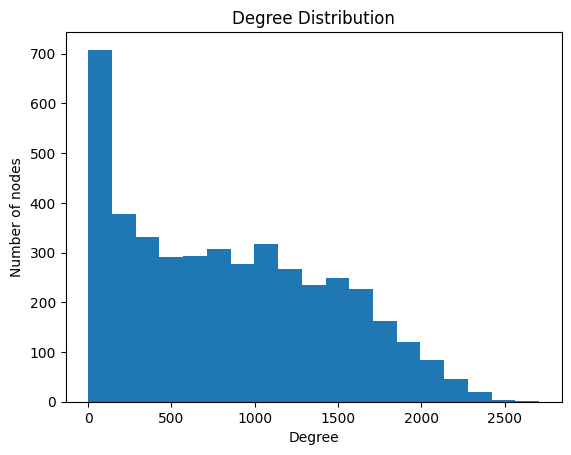

In [11]:
degrees = [degree for node, degree in G.degree()]  # Collects degrees of all nodes in the graph.

# Plotting the histogram of node degrees.
plt.hist(degrees, bins=np.linspace(0, max(degrees), 20))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()

In [12]:
# Prepare graph data for PyTorch Geometric
node_mapping = {node: idx for idx, node in enumerate(G.nodes())}  # Creates a mapping from node names to contiguous indices.
edge_index = torch.tensor([[node_mapping[s], node_mapping[t]] for s, t in G.edges()], dtype=torch.long).t().contiguous()  # Constructs an edge index tensor for use in PyTorch Geometric.
x = torch.tensor([G.nodes[node]['image_feature'] for node in G.nodes()], dtype=torch.float)  # Creates a tensor of node features from the graph.

data = Data(x=x, edge_index=edge_index)  # Initializes a PyTorch Geometric Data object with node features and the edge index.

class GCN(torch.nn.Module):  # Defines a class for the Graph Convolutional Network model.
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 128)  # First GCN layer transforming node features to 128 features.
        self.conv2 = GCNConv(128, len(df['Brand'].unique()))  # Second GCN layer transforming 128 features to the number of unique brands.

    def forward(self, data):  # Defines the forward pass of the model.
        x, edge_index = data.x, data.edge_index  # Extracts node features and edge index from the data.
        x = torch.relu(self.conv1(x, edge_index))  # Applies the first convolution and ReLU activation.
        x = torch.dropout(x, p=0.5, train=self.training)  # Applies dropout for regularization during training.
        x = self.conv2(x, edge_index)  # Applies the second convolution.
        return torch.log_softmax(x, dim=1)  # Applies log softmax activation to get log-probabilities.

model = GCN()  # Instantiates the GCN model.

In [13]:
# Convert brand names to class labels
brand_to_idx = {brand: idx for idx, brand in enumerate(df['Brand'].unique())}  # Creates a dictionary mapping each unique brand to a unique index.
labels = torch.tensor([brand_to_idx[G.nodes[node]['brand']] for node in G.nodes()], dtype=torch.long)  # Maps brand names in graph nodes to indices and converts them to a tensor.

# Prepare the data object with labels
data = Data(x=x, edge_index=edge_index, y=labels)  # Creates a PyTorch Geometric Data object, now including labels for each node.

# Split data into train and test (simple split for illustration)
data.train_mask = torch.rand(data.num_nodes) < 0.8  # Randomly assigns 80% of the nodes to the training set.
data.test_mask = ~data.train_mask  # Assigns the remaining nodes to the test set by taking the complement of the train mask.

# Setup the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)  # Initializes the Adam optimizer with a learning rate of 0.005 for model parameters.

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Defines the device as CUDA if available, otherwise CPU.
model = model.to(device)  # Moves the model to the defined device.
data = data.to(device)  # Moves the data to the defined device.

In [14]:
def train():
    model.train()  # Sets the model to training mode (enables dropout, batch normalization).
    optimizer.zero_grad()  # Clears old gradients from the last step.
    out = model(data)  # Computes the forward pass using the model.
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Calculates the loss using only the nodes designated as training data.
    loss.backward()  # Computes the gradient of the loss w.r.t. the parameters.
    optimizer.step()  # Updates the parameters based on the gradients.
    return loss.item()  # Returns the numeric value of the loss.

def test():
    model.eval()  # Sets the model to evaluation mode (disables dropout, batch normalization).
    with torch.no_grad():  # Disables gradient calculation to save memory and speed up computation.
        logits = model(data)  # Computes the model's output.
        pred = logits.argmax(dim=1)  # Finds the prediction with the highest probability.
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Checks which predictions match the true labels in the test set.
        test_acc = test_correct.sum().item() / data.test_mask.sum().item()  # Calculates the accuracy of the predictions.
    return test_acc  # Returns the test accuracy.

# Lists to store metrics
train_losses = []  # Initializes a list to store training losses.
test_accuracies = []  # Initializes a list to store test accuracies.

# Number of epochs
epochs = 500  # Sets the number of epochs (full cycles through the training data).

for epoch in range(epochs):
    loss = train()  # Executes the training function and gets the loss.
    train_losses.append(loss)  # Appends the current loss to the list of training losses.

    if epoch % 10 == 0:  # Tests the model every 10 epochs.
        test_acc = test()  # Executes the testing function and gets the accuracy.
        test_accuracies.append((epoch, test_acc))  # Appends the current epoch and test accuracy to the list.
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')  # Prints the epoch, loss, and test accuracy.


Epoch: 0, Loss: 5.1932, Test Acc: 0.0140
Epoch: 10, Loss: 6.2841, Test Acc: 0.0478
Epoch: 20, Loss: 5.0868, Test Acc: 0.0653
Epoch: 30, Loss: 4.7822, Test Acc: 0.0723
Epoch: 40, Loss: 4.5278, Test Acc: 0.0688
Epoch: 50, Loss: 4.3199, Test Acc: 0.0711
Epoch: 60, Loss: 4.1699, Test Acc: 0.0897
Epoch: 70, Loss: 3.7049, Test Acc: 0.1189
Epoch: 80, Loss: 3.3894, Test Acc: 0.1538
Epoch: 90, Loss: 3.1576, Test Acc: 0.1550
Epoch: 100, Loss: 2.9613, Test Acc: 0.1690
Epoch: 110, Loss: 2.7345, Test Acc: 0.1900
Epoch: 120, Loss: 2.6770, Test Acc: 0.2110
Epoch: 130, Loss: 2.4131, Test Acc: 0.2145
Epoch: 140, Loss: 2.4236, Test Acc: 0.2238
Epoch: 150, Loss: 2.3170, Test Acc: 0.2436
Epoch: 160, Loss: 2.1303, Test Acc: 0.2343
Epoch: 170, Loss: 2.1264, Test Acc: 0.2471
Epoch: 180, Loss: 1.9727, Test Acc: 0.2483
Epoch: 190, Loss: 1.9498, Test Acc: 0.2506
Epoch: 200, Loss: 1.8791, Test Acc: 0.2646
Epoch: 210, Loss: 1.7155, Test Acc: 0.2739
Epoch: 220, Loss: 1.8366, Test Acc: 0.2832
Epoch: 230, Loss: 1.59

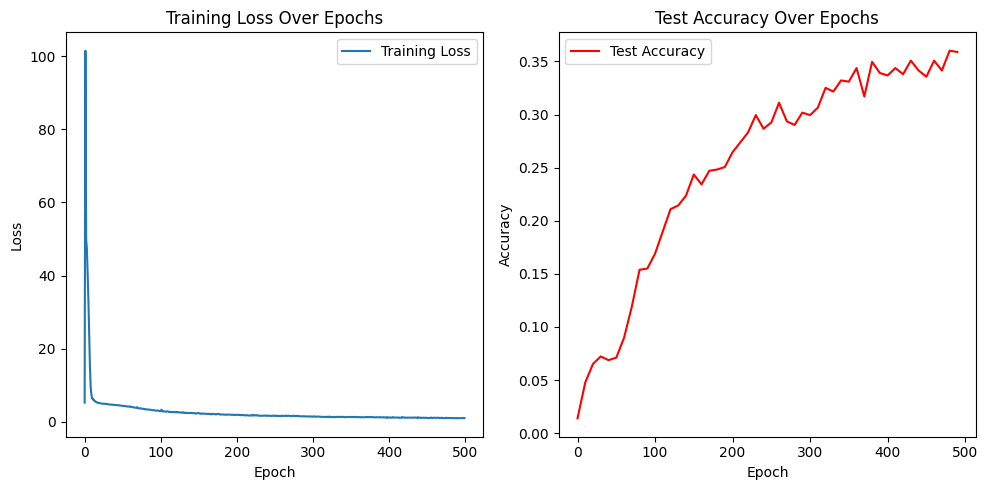

In [15]:
# Plots the training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plots the test accuracy
plt.subplot(1, 2, 2)
epochs, accs = zip(*test_accuracies)  # Unzip the list of tuples
plt.plot(epochs, accs, label='Test Accuracy', color='r')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Interpretation

Training Loss Over Epochs:

The training loss starts off very high and sees a sharp decrease, stabilizing quickly within the first few epochs. This indicates that the model is learning from the training data effectively. However, the rapid decline and subsequent plateau may suggest that the model is not continuing to learn much after the initial epochs. It could also mean that the model is too simple and is unable to capture more complex patterns in the data after the initial learning phase.

Test Accuracy Over Epochs:

The test accuracy shows a gradual increase over time, suggesting that the model is becoming better at generalizing to unseen data. The increase is not smooth; it has some variability, which is common in training processes due to the stochastic nature of most optimization algorithms like Adam. However, the overall trend is upwards, although the accuracy is relatively low, leveling off at around 35%.

Comparing to the CNN model from the previous assignment:

Model Architecture:
- MobileNetV2 is a CNN designed for image data and benefits from extensive pre-training on ImageNet, a large and diverse dataset that helps it learn a wide range of features applicable to many image recognition tasks. The architecture is highly optimized for visual pattern recognition within images.
- GCN, on the other hand, is structured to handle graph data. While it can process image data represented as graphs, its primary strength lies in capturing the relationships between data points (nodes) and not just the standalone features of each point.

Pre-training and Transfer Learning:
- The MobileNetV2 model has been pre-trained on a large dataset (ImageNet), which likely includes a wide variety of images. Transfer learning allows it to apply this broad knowledge base to the specific task at hand, requiring only fine-tuning on a new dataset to achieve high accuracy.
- The GCN model lacks this pre-trained advantage specifically for image data, which means it might require more data or more epochs to learn from scratch, or it may simply not be as suitable for the task as MobileNetV2 if the task is purely image-based classification.

Data Representation:
- The success of MobileNetV2 in the previous assignment might be due to the dataset being primarily image-centric, where each data point is an image and benefits from the spatial hierarchies learned by CNNs.
- GCNs are inherently designed for data that includes not only features but also connections or relationships, which means they might excel in scenarios where the dataset captures complex interrelationships between data points, like social networks or molecular structures.


In summary, the MobileNetV2 model significantly outperforms the GCN model on the perfume dataset, achieving high validation accuracy through effective transfer learning from pre-trained ImageNet weights. Its architecture is particularly well-suited to the image-based aspects of the dataset. The GCN's lower performance indicates that it may require additional refinement and data representation to fully utilize its graph-based approach.

## Bibliography

- Bruno C.L. Rodrigues, Santana, V. V., Queiroz, L. P., Rebello, C. M., & Idelfonso B.R. Nogueira. (2024). Harnessing Graph Neural Networks to Craft Fragrances Based on Consumer Feedback. Computers & Chemical Engineering, 185, 108674–108674. https://doi.org/10.1016/j.compchemeng.2024.108674
- Layan Alabdullatef. (2020, September 2). Complete Guide to Adam Optimization - Layan Alabdullatef - Medium. Medium; Medium. https://medium.com/@LayanSA/complete-guide-to-adam-optimization-1e5f29532c3d
- PyTorch. (2023). Adam. Pytorch.org. https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
- PyTorch Geometric. (2024). torch_geometric.nn.models.GCN — pytorch_geometric  documentation. Readthedocs.io. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.GCN.html

## AI Statement

I used ChatGPT for help with debugging, adding comments to code and editing the narrative for clarity and flow.